In [2]:
import nasdaqdatalink  # conda install nasdaq-data-link
import yahoo_fin.stock_info as yf  # conda install yahoo_fin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, HuberRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
import xgboost as xgb  # conda install xgboost

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model  # pip install arch

import warnings
warnings.simplefilter("ignore")

plt.rcParams.update({'figure.figsize': (10, 6), 'figure.dpi': 80}) # set fig size

## Data gathering and pre-processing 

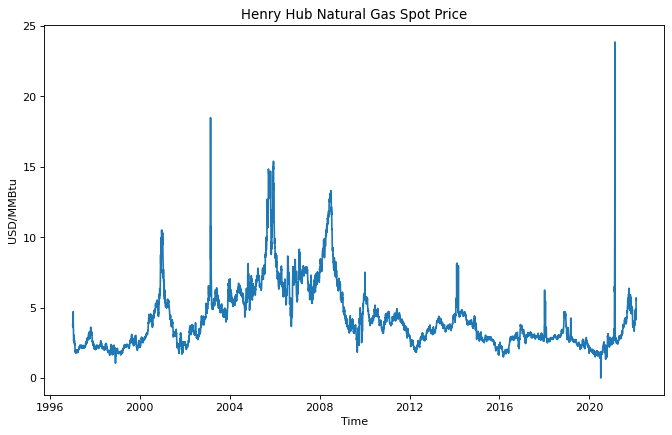

In [3]:
HH_spot_price = nasdaqdatalink.get('EIA/NG_RNGWHHD_D', 
                                   start_date='1997-01-07', 
                                   end_date='2022-01-31', 
                                   authtoken='Gymx-B5owcdhypB7ydu8')
plt.plot(HH_spot_price)
plt.title('Henry Hub Natural Gas Spot Price')
plt.ylabel('USD/MMBtu')
plt.xlabel('Time')
#plt.savefig('HH.jpg', bbox_inches='tight')

plt.show()

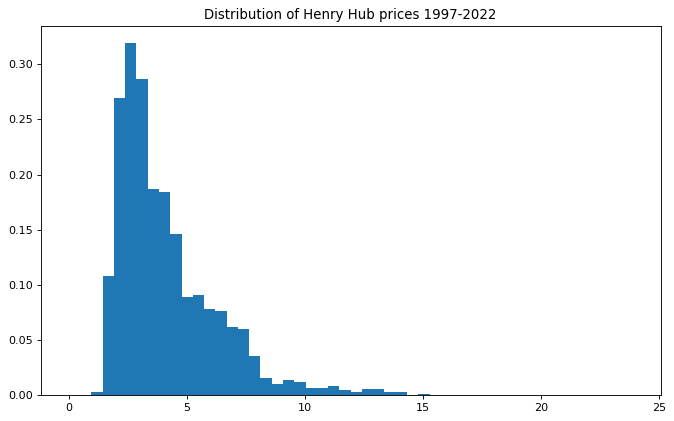

In [4]:
plt.hist(HH_spot_price, bins=50, density=True)
plt.title('Distribution of Henry Hub prices 1997-2022')
plt.show()

In [5]:
def get_datasets(source, startdate='1997-01-01', enddate='2021-12-31', auth="Gymx-B5owcdhypB7ydu8"):
    try:
        return nasdaqdatalink.get(source, start_date=startdate, end_date=enddate, authtoken=auth)
    except:
        return yf.get_data(source, start_date=startdate, end_date=enddate, interval='1mo')['adjclose'].to_frame()

features = [
  'US_gas_consumption',
  'US_gas_supply',
  'US_storage_volume',
  'US_gas_exports',
  'US_gas_imports',
  'gas_rig_count',
  'gas_marketed_production',
  'WTI_spot_price',
  #'US_PMI',  missing values
  'US_CPI',
  'dow_jones',
  '3m_treasury',
  '5y_treasury',
  #'USD/EUR'  missing values
]

API_mapping = {
    'HH_spot_price':'EIA/NG_RNGWHHD_M',
    'US_gas_consumption':'EIA/STEO_NGTCPUS_M',
    'US_gas_supply':'EIA/STEO_NGPSUPP_M',
    'US_storage_volume':'EIA/NG_N5030US2_M',
    'US_gas_exports':'EIA/NG_N9130US2_M',
    'US_gas_imports':'EIA/NG_N9100US2_M',
    'gas_rig_count':'EIA/NG_E_ERTRRG_XR0_NUS_C_M',
    'gas_marketed_production':'EIA/STEO_NGMPPUS_M',
    'WTI_spot_price':'EIA/PET_RWTC_M',
    'US_PMI':'FRED/NAPM',
    'US_CPI':'RATEINF/CPI_USA',
    'dow_jones':'^DJI',
    '3m_treasury':'^IRX',
    '5y_treasury':'^FVX',
    'USD/EUR':'EUR=X'
}

In [6]:
df = pd.DataFrame()  # contains all features indexed by date
for feature in features:
    data = get_datasets(API_mapping[feature])
    df = pd.concat([df, data], axis=1, join='outer')
df = df.set_axis(features, axis=1)  # rename the columns to match the features
df = df.resample('M').mean()  # align monthly indices
df

,US_gas_consumption,US_gas_supply,US_storage_volume,US_gas_exports,US_gas_imports,gas_rig_count,gas_marketed_production,WTI_spot_price,US_CPI,dow_jones,3m_treasury,5y_treasury
1997-01-31,81.946492,84.198499,5843054.0,12028.0,278288.0,478.0,54.851923,25.13,159.100,6813.089844,5.010,6.250
1997-02-28,81.200033,74.303301,5481074.0,12443.0,240545.0,492.0,55.022983,22.18,159.600,6877.740234,5.070,6.368
1997-03-31,69.557141,65.940162,5335550.0,16276.0,256985.0,518.0,55.180090,20.97,160.000,6583.479980,5.170,6.759
1997-04-30,61.401220,57.639494,5393231.0,13872.0,238178.0,526.0,54.345237,19.70,160.200,7009.000000,5.100,6.565
1997-05-31,53.216020,49.180900,5704423.0,10097.0,241732.0,541.0,54.601192,20.82,160.100,7331.000000,4.820,6.508
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,77.733115,78.083497,7352090.0,563650.0,220959.0,100.0,102.349916,67.70,273.567,35360.730469,0.040,0.772
2021-09-30,70.336595,70.231507,7742706.0,535660.0,220206.0,101.0,101.664004,71.65,274.310,33843.921875,0.028,0.997
2021-10-31,72.180108,73.880276,8103188.0,545121.0,228203.0,99.0,103.833832,81.48,276.589,35819.558594,0.048,1.188
2021-11-30,88.210309,91.001054,7971448.0,557080.0,242405.0,102.0,105.280529,79.15,277.948,34483.718750,0.048,1.150


In [7]:
df.describe()

,US_gas_consumption,US_gas_supply,US_storage_volume,US_gas_exports,US_gas_imports,gas_rig_count,gas_marketed_production,WTI_spot_price,US_CPI,dow_jones,3m_treasury,5y_treasury
count,300.000000,300.000000,2.990000e+02,299.000000,299.000000,299.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,68.470836,68.489427,6.828658e+06,139329.458194,287623.341137,654.501672,67.328933,55.867833,213.084927,14740.199618,1.881103,2.927557
std,15.157503,15.781204,8.011130e+05,139443.866511,55095.310954,434.360908,15.995253,27.776837,32.265508,6905.968110,1.966070,1.745078
min,45.612300,45.068123,5.041971e+06,9527.000000,174225.000000,70.000000,46.698040,11.350000,159.100000,6583.479980,0.003000,0.215000
25%,55.396117,54.453185,6.177023e+06,47541.000000,241327.500000,204.000000,54.655167,30.580000,183.650000,10138.939941,0.090000,1.511000
50%,65.679200,66.156363,6.865772e+06,90432.000000,281970.000000,614.000000,59.434816,53.715000,216.451500,11785.500000,1.192000,2.559000
75%,78.529066,79.239082,7.443056e+06,158527.500000,327415.000000,954.000000,77.766795,75.265000,238.056250,17733.350098,3.808750,4.416000
max,110.461323,110.327827,8.384087e+06,595411.000000,426534.000000,1585.000000,106.019400,133.880000,278.802000,36338.300781,6.150000,6.759000


### Missing data?

In [8]:
for feature in features:
    print('Missing', feature, 'data:', np.round(df[feature].isna().sum()/df.shape[0]*100, 4), '%')

Missing US_gas_consumption data: 0.0 %
Missing US_gas_supply data: 0.0 %
Missing US_storage_volume data: 0.3333 %
Missing US_gas_exports data: 0.3333 %
Missing US_gas_imports data: 0.3333 %
Missing gas_rig_count data: 0.3333 %
Missing gas_marketed_production data: 0.0 %
Missing WTI_spot_price data: 0.0 %
Missing US_CPI data: 0.0 %
Missing dow_jones data: 0.0 %
Missing 3m_treasury data: 0.0 %
Missing 5y_treasury data: 0.0 %


### Add the lagged value of the spot as a feature

In [10]:
df['HH_spot_price'] = nasdaqdatalink.get('EIA/NG_RNGWHHD_M', start_date='1997-01-07', end_date='2022-01-31')  # current month spot
features += ['HH_spot_price']  # new feature (autoregressive)

df = df.fillna(method="ffill")

### Correlation between the features

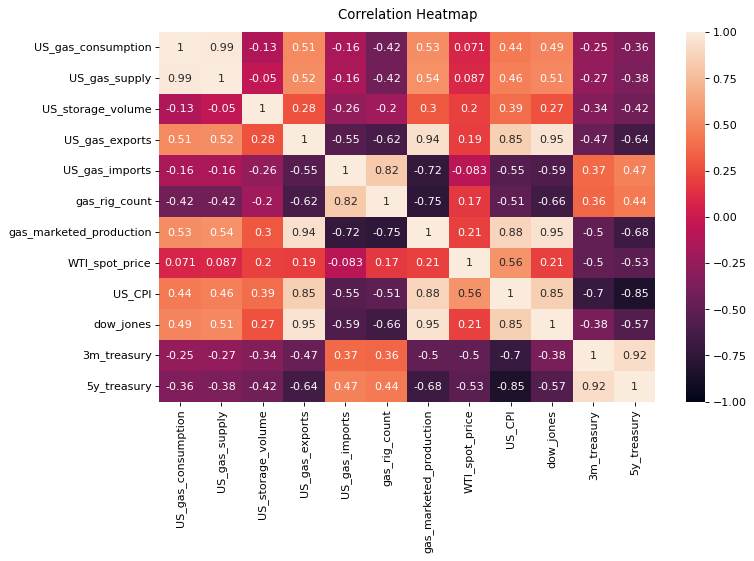

In [9]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

### Feature scaling (normalization)

In [11]:
df_norm = (df-df.mean())/df.std()
df_norm

,US_gas_consumption,US_gas_supply,US_storage_volume,US_gas_exports,US_gas_imports,gas_rig_count,gas_marketed_production,WTI_spot_price,US_CPI,dow_jones,3m_treasury,5y_treasury,HH_spot_price
1997-01-31,0.889042,0.995429,-1.232930,-0.910886,-0.166796,-0.401697,-0.780045,-1.106599,-1.673147,-1.147864,1.591447,1.903893,-0.336141
1997-02-28,0.839795,0.368405,-1.684002,-0.907949,-0.852222,-0.369498,-0.769350,-1.212803,-1.657650,-1.138502,1.621965,1.971512,-0.941884
1997-03-31,0.071668,-0.161538,-1.865343,-0.880819,-0.553666,-0.309702,-0.759528,-1.256365,-1.645253,-1.181112,1.672828,2.195571,-1.063033
1997-04-30,-0.466410,-0.687522,-1.793465,-0.897834,-0.895207,-0.291303,-0.811722,-1.302086,-1.639055,-1.119495,1.637224,2.084401,-0.997799
1997-05-31,-1.006420,-1.223514,-1.405682,-0.924553,-0.830665,-0.256804,-0.795720,-1.261765,-1.642154,-1.072869,1.494808,2.051738,-0.895289
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.611069,0.607943,0.647514,2.993452,-1.207910,-1.271051,2.189461,0.425972,1.874512,2.985900,-0.936438,-1.235221,-0.047248
2021-09-30,0.123091,0.110390,1.134269,2.795341,-1.221585,-1.268751,2.146579,0.568177,1.897539,2.766263,-0.942542,-1.106287,0.460645
2021-10-31,0.244715,0.341599,1.583474,2.862305,-1.076357,-1.273351,2.282233,0.922069,1.968172,3.052339,-0.932369,-0.996836,0.623729
2021-11-30,1.302290,1.426483,1.419310,2.946950,-0.818444,-1.266451,2.372679,0.838186,2.010291,2.858907,-0.932369,-1.018611,0.409389


### Add the month-ahead value of the spot price (objective)

In [13]:
df_norm['next_month_HH_spot_price'] = nasdaqdatalink.get('EIA/NG_RNGWHHD_M', 
                                                         start_date='1997-01-07', 
                                                         end_date='2022-01-31').shift(-1)

df_norm = df_norm.dropna()

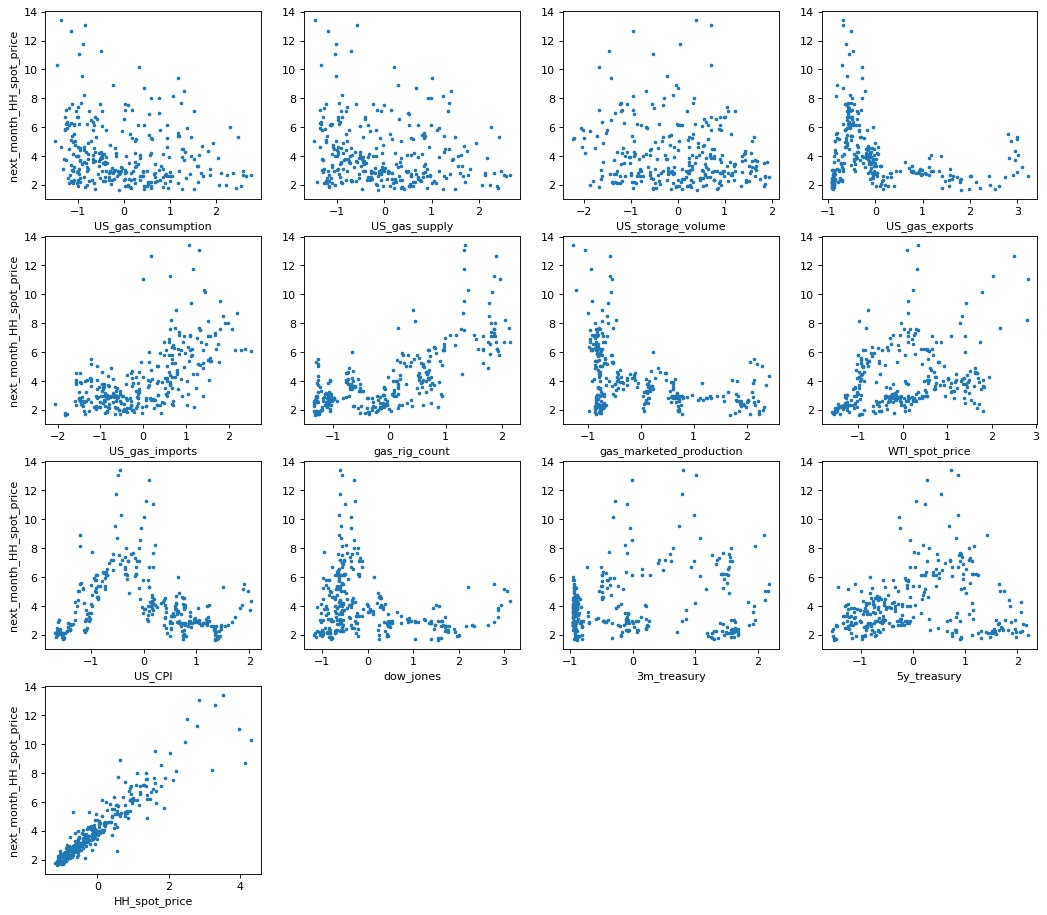

In [14]:
i=1
plt.figure(figsize = (16,14))
for feature in features:
    plt.subplot(4,4,i)
    plt.scatter(df_norm[feature], df_norm['next_month_HH_spot_price'], s=5)
    plt.xlabel(feature)
    if i%4==1: plt.ylabel('next_month_HH_spot_price')
    i += 1
plt.show()

### Train-test split (first approach without k-fold cross-validation)

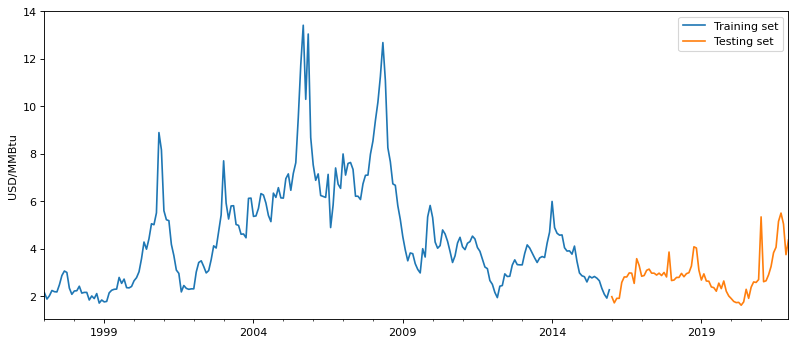

In [45]:
train = df_norm.loc[df_norm.index <= '2015-12-31']  # trained on 1997-2015 (75%)
test = df_norm.loc[df_norm.index >= '2016-01-01']  # tested on 2016-2021 (25%)

fig, ax = plt.subplots(figsize=(12,5))
train['next_month_HH_spot_price'].plot(ax=ax, label='Training set')
test['next_month_HH_spot_price'].plot(ax=ax, label='Testing set')
plt.ylabel('USD/MMBtu')
plt.legend()
plt.show()

In [46]:
X_train, y_train = train.drop('next_month_HH_spot_price', axis=1), train['next_month_HH_spot_price']
X_test, y_test = test.drop('next_month_HH_spot_price', axis=1), test['next_month_HH_spot_price']
X_all, y_all = df_norm[features], df_norm['next_month_HH_spot_price']

## Model #1: Linear Model

#### Least squares

In [17]:
model_ols = LinearRegression()
model_ols.fit(X_train, y_train)
dict(zip(features, model_ols.coef_))

{'US_gas_consumption': -1.0280298560881358,
 'US_gas_supply': 0.9223426421101732,
 'US_storage_volume': -0.1481282655766522,
 'US_gas_exports': 1.5604078310712164,
 'US_gas_imports': -0.14502600055226847,
 'gas_rig_count': -0.009009382189420129,
 'gas_marketed_production': -1.9061359453176254,
 'WTI_spot_price': 0.05110876585586592,
 'US_CPI': -0.12291838801746666,
 'dow_jones': 1.0312577906531266,
 '3m_treasury': 0.11454462031757803,
 '5y_treasury': -0.1845934687485366,
 'HH_spot_price': 1.763649194155547}

In [18]:
y_ols_pred_train = pd.DataFrame(model_ols.predict(X_train), index=y_train.index, columns=['next_month_HH_spot_price'])
y_ols_pred_test = pd.DataFrame(model_ols.predict(X_test), index=y_test.index, columns=['OLS forecast'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_ols_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_ols_pred_test)))

RMSE train: 0.7279003321973531
RMSE test: 2.0193256556784234


#### Ridge regularization

In [19]:
model_ridge = RidgeCV(alphas=np.linspace(.01,1,100))
model_ridge.fit(X_train, y_train)
dict(zip(features, model_ridge.coef_))

{'US_gas_consumption': -0.8142643635658651,
 'US_gas_supply': 0.7169220075777338,
 'US_storage_volume': -0.1189338650358458,
 'US_gas_exports': 1.1917040373374972,
 'US_gas_imports': -0.07836135087475427,
 'gas_rig_count': 0.0013523963181647503,
 'gas_marketed_production': -1.559929091628394,
 'WTI_spot_price': 0.07006487493333635,
 'US_CPI': -0.11146264131494021,
 'dow_jones': 0.8990761253789756,
 '3m_treasury': 0.09547234745901179,
 '5y_treasury': -0.16157553188270235,
 'HH_spot_price': 1.7707900297097439}

In [20]:
y_ridge_pred_train = pd.DataFrame(model_ridge.predict(X_train), index=y_train.index, columns=['next_month_HH_spot_price'])
y_ridge_pred_test = pd.DataFrame(model_ridge.predict(X_test), index=y_test.index, columns=['Ridge forecast'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_ridge_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_ridge_pred_test)))

RMSE train: 0.7297390768718576
RMSE test: 1.5790717543445092


#### Lasso regularization

In [21]:
model_lasso = LassoCV(alphas=np.linspace(.01,1,100))
model_lasso.fit(X_train, y_train)
dict(zip(features, model_lasso.coef_))

{'US_gas_consumption': -0.004433764095792176,
 'US_gas_supply': -0.0,
 'US_storage_volume': 0.0,
 'US_gas_exports': 0.0,
 'US_gas_imports': 0.0671204398181261,
 'gas_rig_count': 0.05611392241886524,
 'gas_marketed_production': -0.0,
 'WTI_spot_price': 0.018081946962694648,
 'US_CPI': 0.0,
 'dow_jones': 0.0,
 '3m_treasury': 0.0,
 '5y_treasury': 0.0,
 'HH_spot_price': 1.894924506964035}

In [22]:
y_lasso_pred_train = pd.DataFrame(model_lasso.predict(X_train), index=y_train.index, columns=['next_month_HH_spot_price'])
y_lasso_pred_test = pd.DataFrame(model_lasso.predict(X_test), index=y_test.index, columns=['Lasso forecast'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_lasso_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_lasso_pred_test)))

RMSE train: 0.7831905569884221
RMSE test: 0.588954045287962


#### Huber regression

In [23]:
model_huber = HuberRegressor()  # hyperparameter tuning???
model_huber.fit(X_train, y_train)
dict(zip(features, model_huber.coef_))

{'US_gas_consumption': -0.3372742688778983,
 'US_gas_supply': 0.24851079365442313,
 'US_storage_volume': -0.06967256570381264,
 'US_gas_exports': 1.2362857569845935,
 'US_gas_imports': -0.033729007919130846,
 'gas_rig_count': -0.025548545427621982,
 'gas_marketed_production': -1.3142458155102519,
 'WTI_spot_price': 0.034803839485932894,
 'US_CPI': -0.025838230196412848,
 'dow_jones': 0.7354421421706723,
 '3m_treasury': 0.10122919093816514,
 '5y_treasury': -0.057729170825062535,
 'HH_spot_price': 1.7800012174476307}

In [24]:
y_huber_pred_train = pd.DataFrame(model_huber.predict(X_train), index=y_train.index, columns=['next_month_HH_spot_price'])
y_huber_pred_test = pd.DataFrame(model_huber.predict(X_test), index=y_test.index, columns=['Huber forecast'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_huber_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_huber_pred_test)))

RMSE train: 0.7415170666487022
RMSE test: 1.7602207745641039


### Plot of all linear models

[]

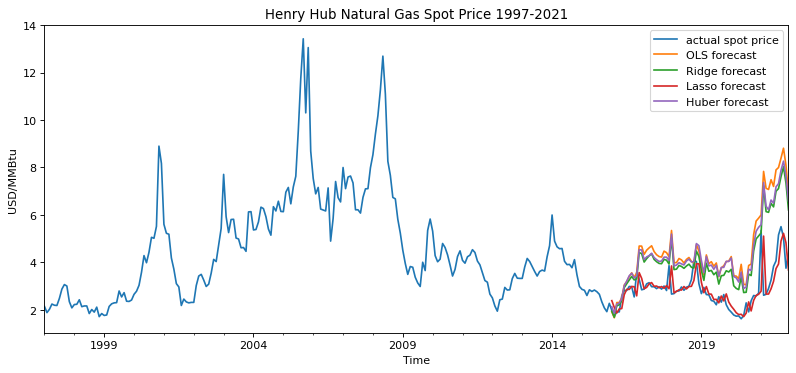

In [25]:
fig, ax = plt.subplots(figsize=(12,5))
y_all.plot(ax=ax, label='actual spot price')
linear_models_data = [y_ols_pred_test, y_ridge_pred_test, y_lasso_pred_test, y_huber_pred_test]
for linear_model in linear_models_data:
    linear_model.plot(ax=ax)
plt.ylabel('USD/MMBtu')
plt.xlabel('Time')
plt.title('Henry Hub Natural Gas Spot Price 1997-2021')
plt.legend()
#plt.savefig('linear_models.jpg', bbox_inches='tight')
plt.plot()


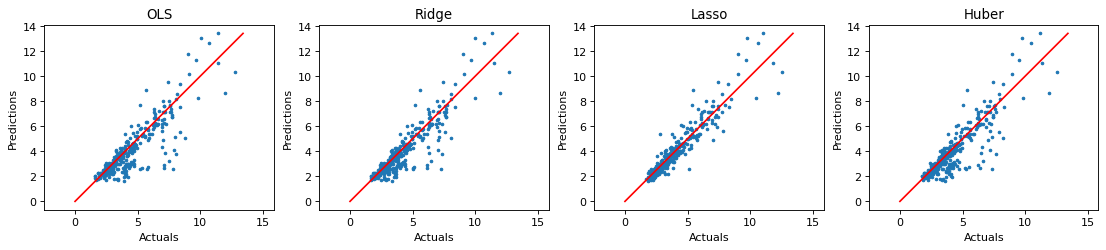

In [26]:
y_ols_pred = pd.DataFrame(model_ols.predict(X_all), index=y_all.index)
y_ridge_pred = pd.DataFrame(model_ridge.predict(X_all), index=y_all.index)
y_lasso_pred = pd.DataFrame(model_lasso.predict(X_all), index=y_all.index)
y_huber_pred = pd.DataFrame(model_huber.predict(X_all), index=y_all.index)
linear_models_y_all = [y_ols_pred, y_ridge_pred, y_lasso_pred, y_huber_pred]
linear_models_titles = ['OLS', 'Ridge', 'Lasso', 'Huber']

i=1
plt.figure(figsize = (17,3))
for lin_model in linear_models_y_all:
    plt.subplot(1,4,i)
    plt.scatter(lin_model, y_all, s=5)
    p1 = max(max(lin_model), max(y_all))
    p2 = min(min(lin_model), min(y_all))
    plt.plot([p1, p2], [p1, p2], c='r')
    plt.xlabel('Actuals')
    plt.ylabel('Predictions')
    plt.title(linear_models_titles[i-1])
    plt.axis('equal')
    i += 1
#plt.savefig('lin_actvspred.jpg', bbox_inches='tight')
plt.show()

## Model #2: Support Vector Regression

#### Hyper parameter tuning (GridSearch cross-validation)

In [27]:
reg_sv = SVR()
p_grid = {'C':[100,1000,10000], 'kernel':['rbf', 'poly']}
search = GridSearchCV(estimator=reg_sv, param_grid=p_grid)
search.fit(X_train, y_train.ravel())
sv_preds = search.best_estimator_
y_SVR_pred_train = sv_preds.predict(X_train)
y_SVR_pred_test = pd.DataFrame(sv_preds.predict(X_test), index=X_test.index, columns=['SVR forecast'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_SVR_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_SVR_pred_test)))

RMSE train: 0.1832273231079323
RMSE test: 0.7809679739880893


[]

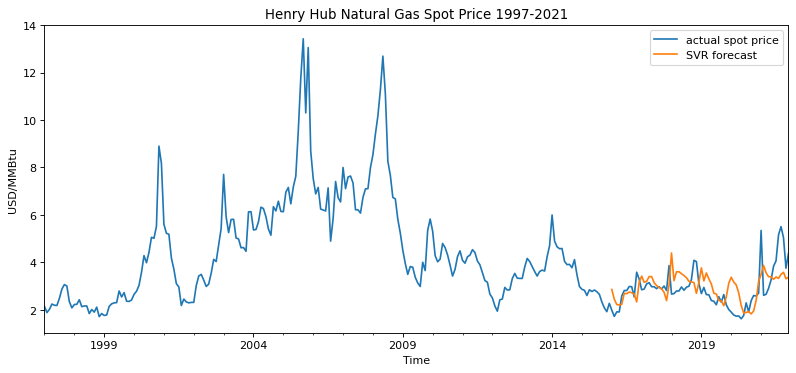

In [28]:
y_SVR_pred = pd.DataFrame(sv_preds.predict(X_test), index=y_test.index, columns=['SVR forecast'])

fig, ax = plt.subplots(figsize=(12,5))
y_all.plot(ax=ax, label='actual spot price')
y_SVR_pred.plot(ax=ax, label='SVR forecast')
plt.ylabel('USD/MMBtu')
plt.xlabel('Time')
plt.title('Henry Hub Natural Gas Spot Price 1997-2021')
#plt.savefig('SVR_models.jpg', bbox_inches='tight')
plt.legend()
plt.plot()

## Model #3: Decision Trees

#### Regression tree

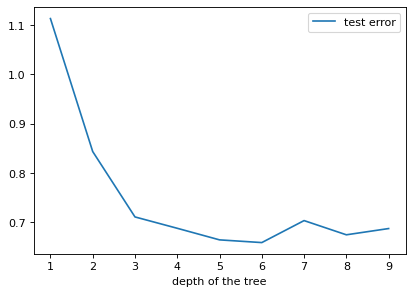

In [30]:
errors=[]
for depth in range(1,10):
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X_train, y_train)
    y_tree_pred_test = pd.DataFrame(tree.predict(X_test), index=y_test.index, columns=['HH_predicted_spot'])
    errors += [np.sqrt(mean_squared_error(y_test, y_tree_pred_test))]
plt.figure(figsize=(6,4))
plt.plot(range(1,10), errors, label='test error')
plt.xlabel('depth of the tree')
plt.legend()
plt.show()

In [31]:
model_tree = DecisionTreeRegressor(max_depth=6)
model_tree.fit(X_train, y_train)
dict(zip(features, model_tree.feature_importances_))

{'US_gas_consumption': 0.0003519565065217425,
 'US_gas_supply': 0.0,
 'US_storage_volume': 0.0018343031108165944,
 'US_gas_exports': 0.004547690171831342,
 'US_gas_imports': 0.011680987506500984,
 'gas_rig_count': 0.002975598574643551,
 'gas_marketed_production': 0.015701857290398892,
 'WTI_spot_price': 0.00438731516354741,
 'US_CPI': 0.0047790208361097345,
 'dow_jones': 0.003910105191726383,
 '3m_treasury': 0.03121895206262238,
 '5y_treasury': 0.00036378977672068516,
 'HH_spot_price': 0.9182484238085603}

In [32]:
y_tree_pred_train = pd.DataFrame(model_tree.predict(X_train), index=y_train.index, columns=['HH_predicted_spot'])
y_tree_pred_test = pd.DataFrame(model_tree.predict(X_test), index=y_test.index, columns=['Decision tree forecast'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_tree_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_tree_pred_test)))

RMSE train: 0.30004738052783003
RMSE test: 0.6587813214650274


#### Bagged tree (Random Forrest)

In [33]:
model_rf = RandomForestRegressor()

param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2', None]}

tscv = TimeSeriesSplit(n_splits=3)
search = GridSearchCV(model_rf, param_grid, cv=tscv)
search.fit(X_train, y_train)

best_rf = search.best_estimator_

dict(zip(features, best_rf.feature_importances_))

{'US_gas_consumption': 0.003541763728249293,
 'US_gas_supply': 0.0054762108345900555,
 'US_storage_volume': 0.0006744715781344262,
 'US_gas_exports': 0.0006409738077752673,
 'US_gas_imports': 0.0014340334704457355,
 'gas_rig_count': 0.02175164046881648,
 'gas_marketed_production': 0.0009915206716113985,
 'WTI_spot_price': 0.0010595294964496228,
 'US_CPI': 0.0009452906954382822,
 'dow_jones': 0.0010600887710482802,
 '3m_treasury': 0.004558274583190037,
 '5y_treasury': 0.004957905226608642,
 'HH_spot_price': 0.9529082966676424}

In [34]:
y_rf_pred_train = pd.DataFrame(best_rf.predict(X_train), index=y_train.index, columns=['HH_predicted_spot'])
y_rf_pred_test = pd.DataFrame(best_rf.predict(X_test), index=y_test.index, columns=['Random Forrest forecast'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_rf_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_rf_pred_test)))

RMSE train: 0.6049111056484829
RMSE test: 0.660730822784341


#### Boosted tree (XGBoost)

In [35]:
# XGBoost with TimeSeriesSplit (cross-validation)
tss = TimeSeriesSplit(n_splits=5, test_size=24)

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_norm):
    print('Fold', fold)
    train = df_norm.iloc[train_idx]
    test = df_norm.iloc[val_idx]

    X_train = train[features]
    y_train = train['next_month_HH_spot_price']

    X_test = test[features]
    y_test = test['next_month_HH_spot_price']

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=200)
    
    fold += 1
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

Fold 0
[0]	validation_0-rmse:4.97262	validation_1-rmse:2.87584
[200]	validation_0-rmse:0.92915	validation_1-rmse:0.50004
[395]	validation_0-rmse:0.42601	validation_1-rmse:0.35757
Fold 1
[0]	validation_0-rmse:4.77406	validation_1-rmse:3.04922
[200]	validation_0-rmse:0.88979	validation_1-rmse:0.54173
[400]	validation_0-rmse:0.40826	validation_1-rmse:0.40062
[401]	validation_0-rmse:0.40771	validation_1-rmse:0.40059
Fold 2
[0]	validation_0-rmse:4.62307	validation_1-rmse:2.34665
[200]	validation_0-rmse:0.86354	validation_1-rmse:0.50764
[400]	validation_0-rmse:0.40832	validation_1-rmse:0.41151
[489]	validation_0-rmse:0.36128	validation_1-rmse:0.41313
Fold 3
[0]	validation_0-rmse:4.45662	validation_1-rmse:2.31658
[200]	validation_0-rmse:0.83555	validation_1-rmse:0.44713
[327]	validation_0-rmse:0.47283	validation_1-rmse:0.41452
Fold 4
[0]	validation_0-rmse:4.31294	validation_1-rmse:2.82609
[200]	validation_0-rmse:0.80939	validation_1-rmse:0.97169
[400]	validation_0-rmse:0.39546	validation_1-rm

In [36]:
print('RMSE test:', np.mean(scores))
print('k-folds RMSE test:', np.round(scores,6))

RMSE test: 0.4909920936684216
k-folds RMSE test: [0.349079 0.397152 0.409342 0.405212 0.894176]


In [47]:
xgboost_tree = xgb.XGBRegressor(n_estimators=500)
xgboost_tree.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
dict(zip(features, xgboost_tree.feature_importances_))

{'US_gas_consumption': 0.0027916108,
 'US_gas_supply': 0.002539681,
 'US_storage_volume': 0.002202298,
 'US_gas_exports': 0.0040245755,
 'US_gas_imports': 0.0037411652,
 'gas_rig_count': 0.06277823,
 'gas_marketed_production': 0.005523921,
 'WTI_spot_price': 0.0016598514,
 'US_CPI': 0.002810477,
 'dow_jones': 0.0047148075,
 '3m_treasury': 0.01232421,
 '5y_treasury': 0.004759168,
 'HH_spot_price': 0.89013}

In [51]:
y_xgb_pred_train = pd.DataFrame(xgboost_tree.predict(X_train), index=y_train.index, columns=['HH_predicted_spot'])
y_xgb_pred_test = pd.DataFrame(xgboost_tree.predict(X_test), index=y_test.index, columns=['XGBoost prediction'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_xgb_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_xgb_pred_test)))

RMSE train: 0.0008954556638263598
RMSE test: 0.6344656133397689


[]

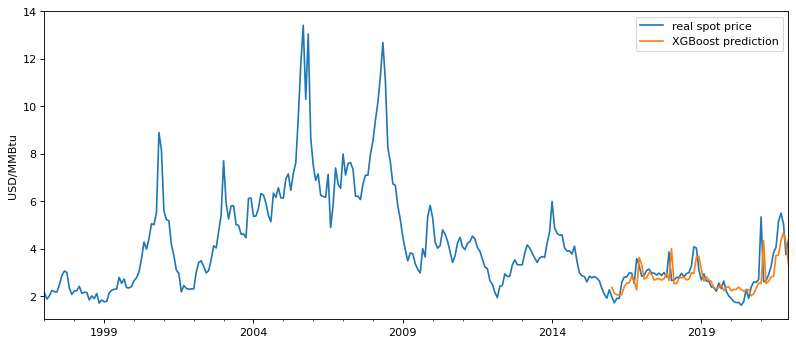

In [52]:
X_train, y_train = train.drop('next_month_HH_spot_price', axis=1), train['next_month_HH_spot_price']
X_test, y_test = test.drop('next_month_HH_spot_price', axis=1), test['next_month_HH_spot_price']
fig, ax = plt.subplots(figsize=(12,5))
y_all.plot(ax=ax, label='real spot price')
y_xgb_pred_test.plot(ax=ax)
plt.ylabel('USD/MMBtu')

plt.legend()
plt.plot()

In [53]:
dict(zip(features, xgboost_tree.feature_importances_))

{'US_gas_consumption': 0.0027916108,
 'US_gas_supply': 0.002539681,
 'US_storage_volume': 0.002202298,
 'US_gas_exports': 0.0040245755,
 'US_gas_imports': 0.0037411652,
 'gas_rig_count': 0.06277823,
 'gas_marketed_production': 0.005523921,
 'WTI_spot_price': 0.0016598514,
 'US_CPI': 0.002810477,
 'dow_jones': 0.0047148075,
 '3m_treasury': 0.01232421,
 '5y_treasury': 0.004759168,
 'HH_spot_price': 0.89013}

[]

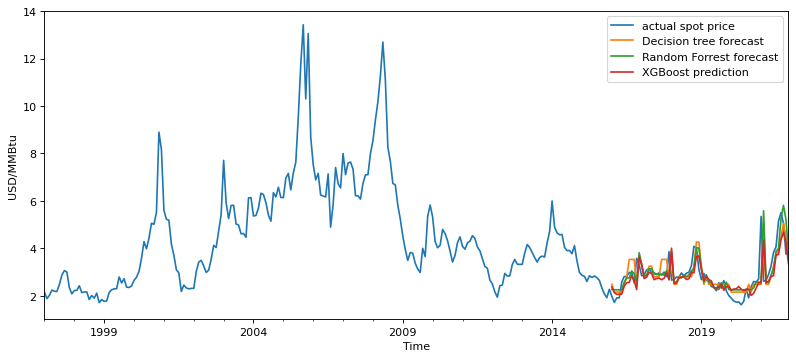

In [54]:
fig, ax = plt.subplots(figsize=(12,5))
y_all.plot(ax=ax, label='actual spot price')
tree_models_data = [y_tree_pred_test, y_rf_pred_test, y_xgb_pred_test]
for tree_model in tree_models_data:
    tree_model.plot(ax=ax)
plt.ylabel('USD/MMBtu')
plt.xlabel('Time')
#plt.title('Henry Hub Natural Gas Spot Price 1997-2021')
plt.legend()
plt.savefig('tree_models.jpg', bbox_inches='tight')
plt.plot()


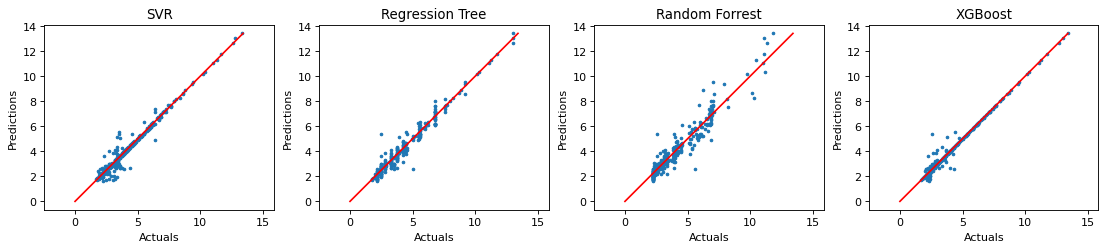

In [55]:
y_svr_pred = pd.DataFrame(sv_preds.predict(X_all), index=y_all.index)
y_tree_pred = pd.DataFrame(model_tree.predict(X_all), index=y_all.index)
y_rf_pred = pd.DataFrame(best_rf.predict(X_all), index=y_all.index)
y_xgb_pred = pd.DataFrame(xgboost_tree.predict(X_all), index=y_all.index)
non_linear_models_y_all = [y_svr_pred, y_tree_pred, y_rf_pred, y_xgb_pred]
non_linear_models_titles = ['SVR', 'Regression Tree', 'Random Forrest', 'XGBoost']

i=1
plt.figure(figsize = (17,3))
for non_lin_model in non_linear_models_y_all:
    plt.subplot(1,4,i)
    plt.scatter(non_lin_model, y_all, s=5)
    p1 = max(max(non_lin_model), max(y_all))
    p2 = min(min(non_lin_model), min(y_all))
    plt.plot([p1, p2], [p1, p2], c='r')
    plt.xlabel('Actuals')
    plt.ylabel('Predictions')
    plt.title(non_linear_models_titles[i-1])
    plt.axis('equal')
    i += 1
#plt.savefig('tree_actvspred.jpg', bbox_inches='tight')
plt.show()

## Model #4: Neural networks models

In [ ]:
from keras.models import Sequential  # pip install tensorflow
from keras.layers import Dense, LSTM

def create_lstm(units=50, activation='relu', optimizer='adam', dropout=0.2, input_shape=(1,1)):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

param_grid = {
    'units': [25, 50, 100],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop'],
    'dropout': [0.1, 0.2],
    'batch_size': [8, 16],
    'epochs': [50, 100]
}

# create the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)
# create the grid search object
lstm_grid = GridSearchCV(estimator=create_lstm(input_shape=(X_train.shape[1],1)),
                         param_grid=param_grid, cv=tscv, verbose=1, n_jobs=-1)
# fit the grid search object to the data
lstm_grid.fit(np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)), y_train)

## Model #5: Autoregressive models

#### Test of stationarity (Augmented Dickey-Fuller test)

In [259]:
adfuller(df_norm['next_month_HH_spot_price'])  # H0: ts is non-stationary

(-3.18756603629313,
 0.02071578163306949,
 0,
 298,
 {'1%': -3.4524859843440754,
  '5%': -2.871288184343229,
  '10%': -2.571964047565425},
 652.7316427372062)

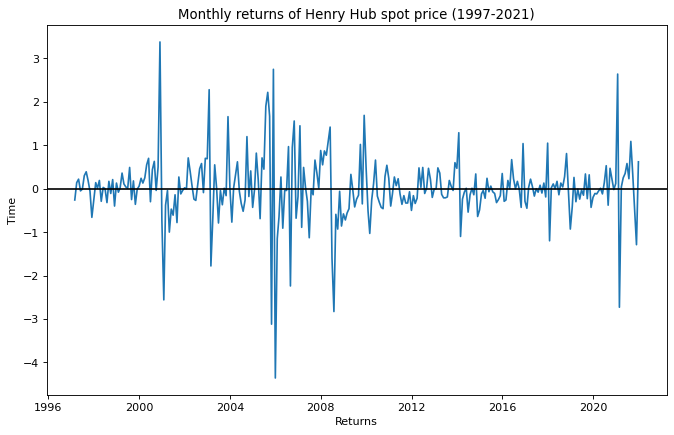

In [67]:
HH_monthly_returns = df_norm['next_month_HH_spot_price']-df_norm['next_month_HH_spot_price'].shift(1)
plt.plot(HH_monthly_returns)
plt.axhline(c='black')
plt.title('Monthly returns of Henry Hub spot price (1997-2021)')
plt.xlabel('Returns')
plt.ylabel('Time')
plt.show()

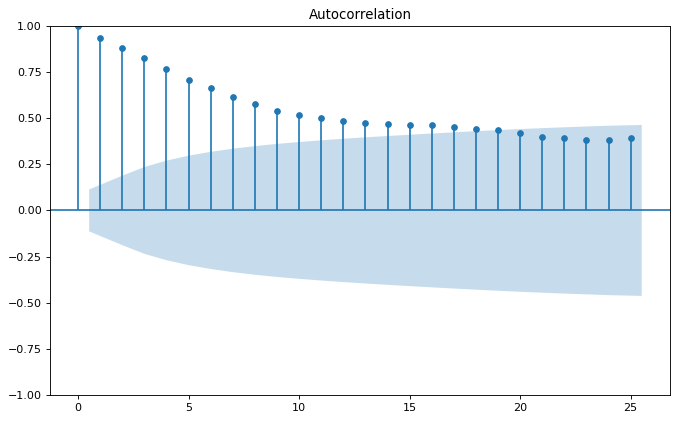

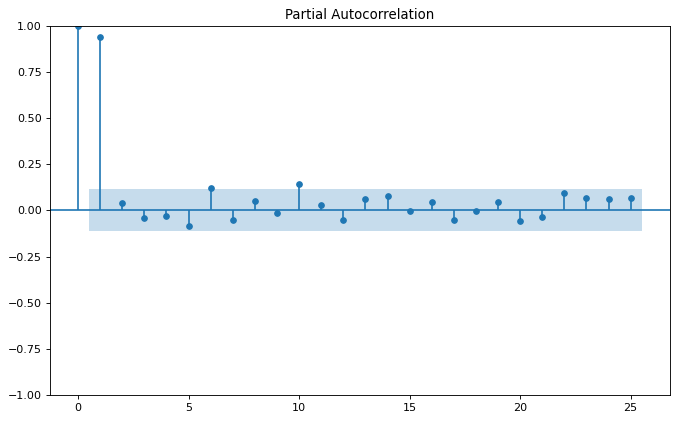

In [260]:
plot_acf(df_norm['next_month_HH_spot_price'])
plot_pacf(df_norm['next_month_HH_spot_price'])
plt.show()

#### GARCH model fitting

In [288]:
garch = arch_model(df_norm['next_month_HH_spot_price'], vol='garch', p=1, o=0, q=0)
garch_fitted = garch.fit()
#garch_fitted.plot()
garch_fitted.summary()
#garch_forecast = garch_fitted.forecast(horizon=12)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1749.5299594580165
Iteration:      2,   Func. Count:     13,   Neg. LLF: 13849.299995893858
Iteration:      3,   Func. Count:     18,   Neg. LLF: 12534.456469074144
Iteration:      4,   Func. Count:     23,   Neg. LLF: 44460.63282495586
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4628.045040328321
Iteration:      6,   Func. Count:     33,   Neg. LLF: 552.7118873096381
Iteration:      7,   Func. Count:     38,   Neg. LLF: 673.4791531424921
Iteration:      8,   Func. Count:     43,   Neg. LLF: 920.6174312924568
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4760.14775598483
Iteration:     10,   Func. Count:     53,   Neg. LLF: 19587.720247367717
Iteration:     11,   Func. Count:     58,   Neg. LLF: 54800.88910541268
Iteration:     12,   Func. Count:     63,   Neg. LLF: 12439.147426243384
Iteration:     13,   Func. Count:     68,   Neg. LLF: 9972.352490145651
Iteration:     14,   Func. Count:     73,   Neg. LLF: 527.14

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - ARCH Model Results                         
====================================================================================
Dep. Variable:     next_month_HH_spot_price   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -477.405
Distribution:                        Normal   AIC:                           960.810
Method:                  Maximum Likelihood   BIC:                           971.911
                                              No. Observations:                  299
Date:                      Tue, May 09 2023   Df Residuals:                      298
Time:                              13:34:07   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             3.0250      0.132     22.866 1.010e-115 [  2.766,  3.284]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1543  4.631e-02      3.332  8.624e-04 [6.354e-02,  0.245]
alpha[1]       1.0000  6.919e-02     14.453  2.384e-47   [  0.864,  1.136]
==========================================================================

Covariance estimator: robust
"""

#### ARIMA model fitting

In [63]:
train, test = ts.loc[ts.index <= '2016-12-31'], ts.loc[ts.index >= '2017-01-01']
arima_model = auto_arima(train, start_p=0, d=None, start_q=0, max_p=5, max_d=5, max_q=5)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  239
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -277.666
Date:                Fri, 05 May 2023   AIC                            561.332
Time:                        14:26:17   BIC                            571.761
Sample:                    02-28-1997   HQIC                           565.534
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9810      0.026    -38.437      0.000      -1.031      -0.931
ma.L1          0.9507      0.039     24.374      0.000       0.874       1.027
sigma2         0.5973      0.028     21.593      0.000       0.543       0.652
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               460.08
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## APPENDIX

#### Unit mapping of the features

In [68]:
features_units_mapping = {
    'HH_spot_price':'USD/MMBtu',
    'US_gas_consumption':'bcf/day',
    'US_gas_supply':'bcf/day',
    'US_storage_volume':'MMcf',
    'US_gas_exports':'MMcf',
    'US_gas_imports':'MMcf',
    'gas_futures_1':'USD/MMBtu',
    'WTI_spot_price':'USD/barrel',
    'TTF_spot_price':'EUR/MWh',
}

#### K-fold cross validation for time series

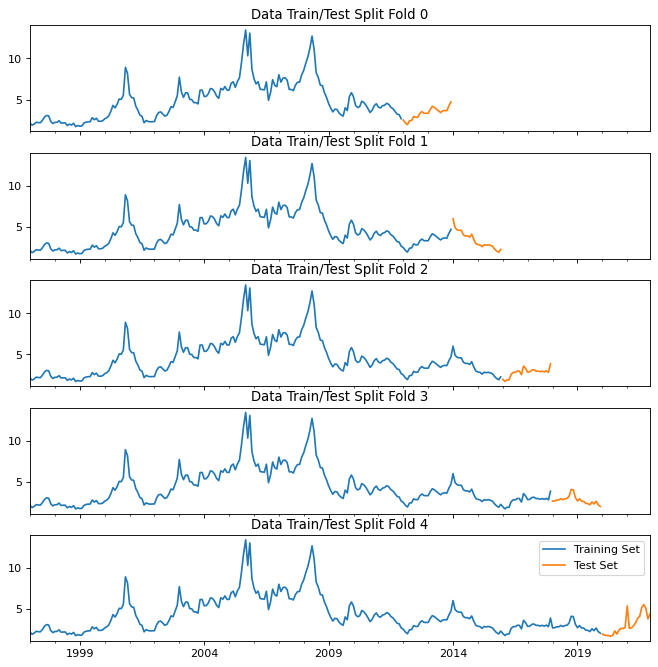

In [69]:
tss = TimeSeriesSplit(n_splits=5, test_size=24)

fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_norm):
    train = df_norm.iloc[train_idx]
    test = df_norm.iloc[val_idx]
    train['next_month_HH_spot_price'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['next_month_HH_spot_price'].plot(ax=axs[fold],
                         label='Test Set')
    fold += 1
plt.legend()
plt.savefig('ts_kfold.jpg', bbox_inches='tight')
plt.show()
